## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

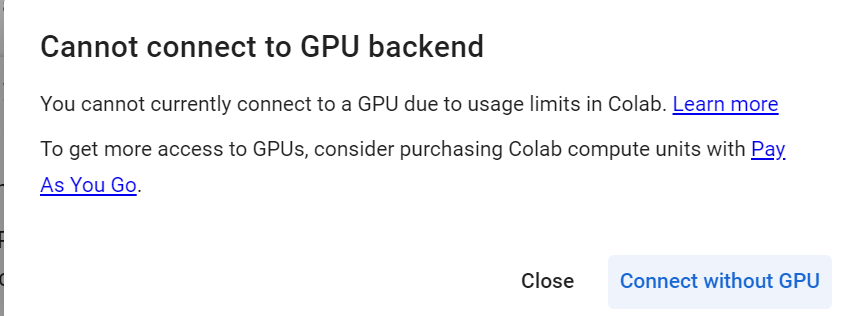

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [2]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## **Loading the dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path="drive/MyDrive/AIML/StockMarket"

Mounted at /content/drive


In [4]:
df = pd.read_csv(path+'/stock_news.csv')

In [5]:
stock = df.copy()

## **Data Overview**

In [6]:
df.head(5)


,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [7]:
df.shape


(349, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [9]:
stock['Date'] = pd.to_datetime(stock['Date'])

In [10]:
df.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,349.0,4.622923e+01,6.442817e+00,3.756750e+01,4.174000e+01,4.597500e+01,5.070750e+01,6.681750e+01
High,349.0,4.670046e+01,6.507321e+00,3.781750e+01,4.224500e+01,4.602500e+01,5.085000e+01,6.706250e+01
Low,349.0,4.574539e+01,6.391976e+00,3.730500e+01,4.148250e+01,4.564000e+01,4.977750e+01,6.586250e+01
Close,349.0,4.492632e+01,6.398338e+00,3.625413e+01,4.024691e+01,4.459692e+01,4.911079e+01,6.480523e+01
Volume,349.0,1.289482e+08,4.317031e+07,4.544800e+07,1.032720e+08,1.156272e+08,1.511252e+08,2.444392e+08
Label,349.0,-5.444126e-02,7.151192e-01,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [12]:
# checking duplicate value of data
df.duplicated().sum()

0

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

#### Observations on Label

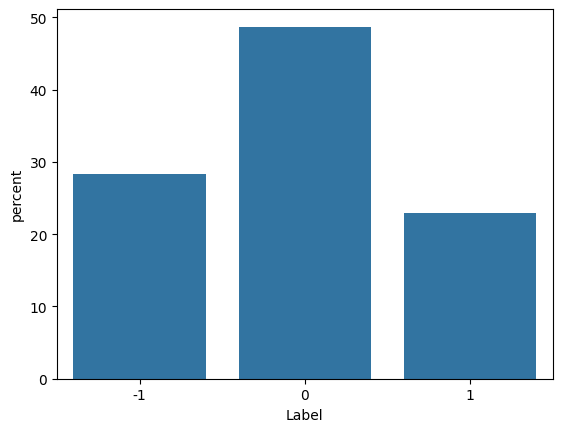

In [13]:
sns.countplot(data=stock, x="Label", stat="percent");

#### Density Plot of Price (Open,High,Low,Close)

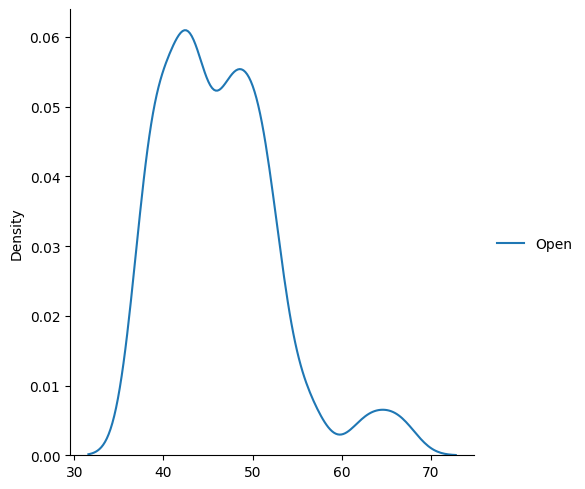

In [14]:
sns.displot(data=stock[['Open']], kind="kde", palette="tab10");


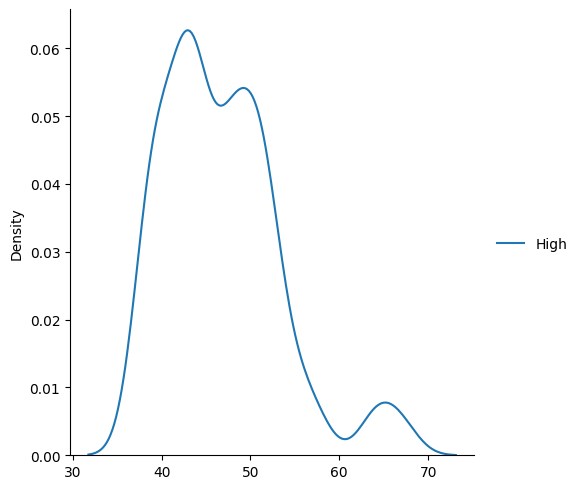

In [15]:
sns.displot(data=stock[['High']], kind="kde", palette="tab10");


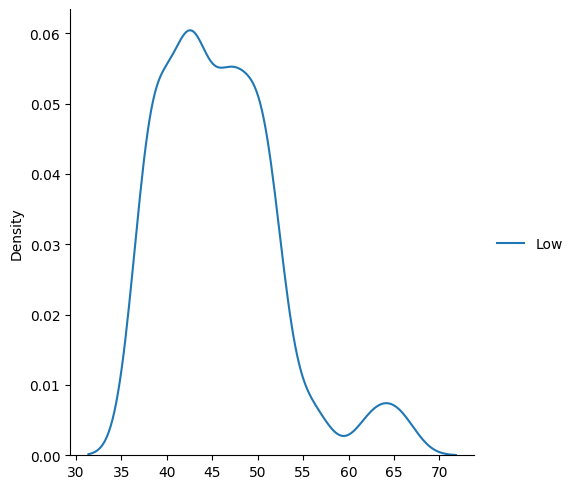

In [16]:
sns.displot(data=stock[['Low']], kind="kde", palette="tab10");


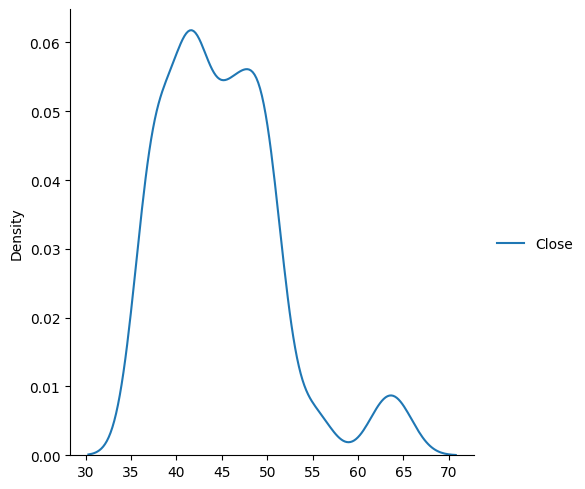

In [17]:
sns.displot(data=stock[['Close']], kind="kde", palette="tab10");


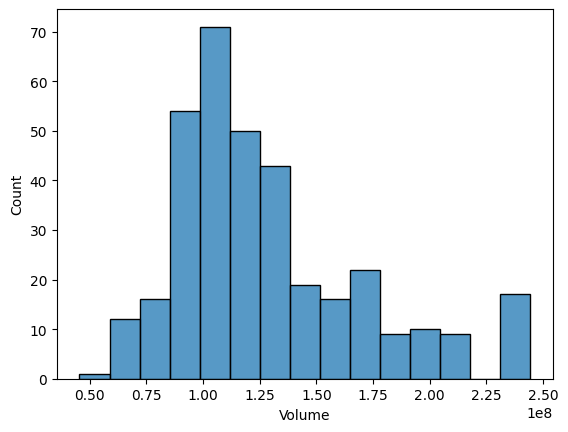

In [18]:
sns.histplot(stock, x='Volume');

#### Observations on News length

In [19]:
stock['news_len'] = stock['News'].apply(lambda x: len(x.split(' ')))


stock['news_len'].T

,news_len
0,46
1,51
2,49
3,51
4,50
...,...
344,48
345,41
346,48
347,58


<Axes: xlabel='news_len', ylabel='Count'>

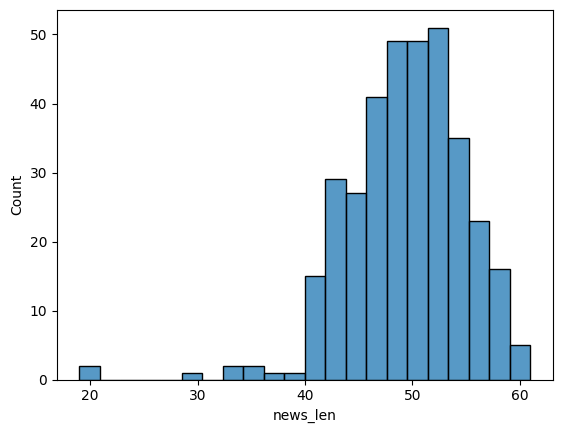

In [20]:
sns.histplot(data=stock,x="news_len")

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

#### Correlation

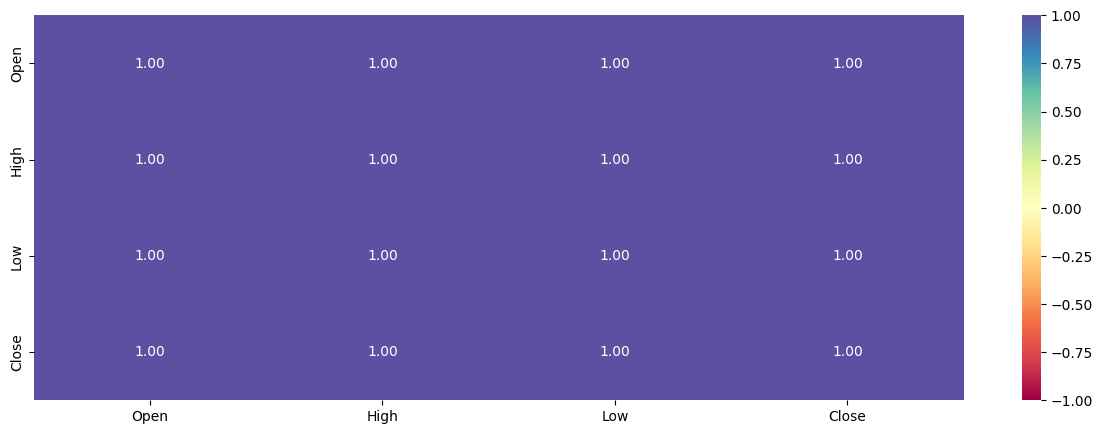

In [21]:
col_list = ['Open', 'High', 'Low', 'Close']
plt.figure(figsize=(15, 5))
sns.heatmap(
    stock[col_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
);

#### Label vs Price (Open, High, Low, Close)

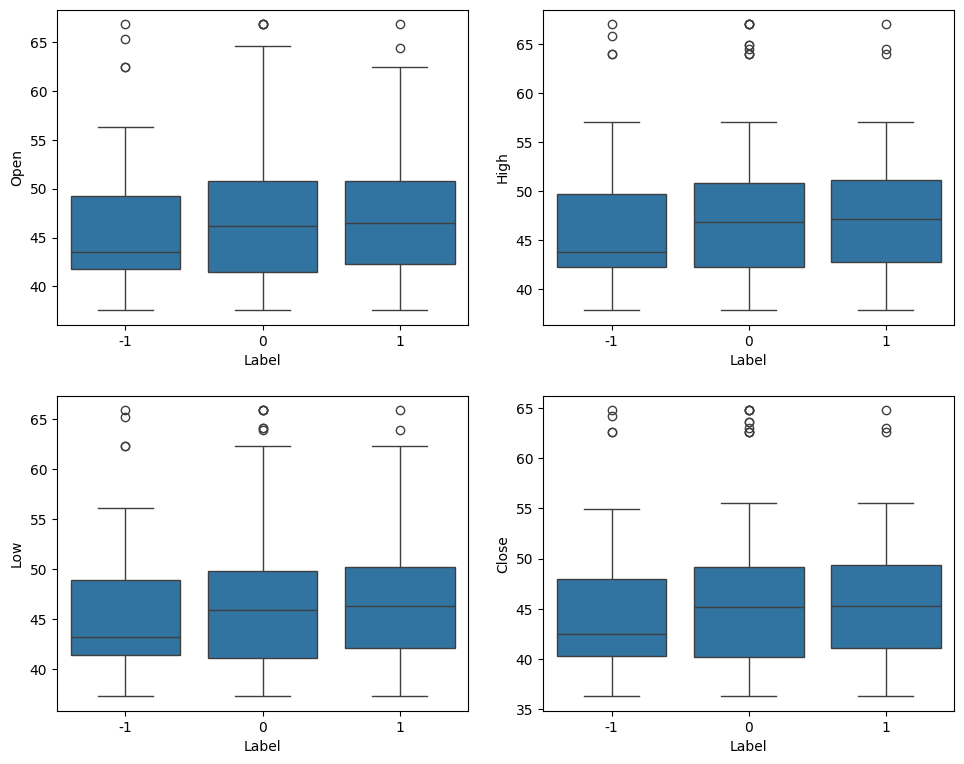

In [22]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

#### Label vs Volume

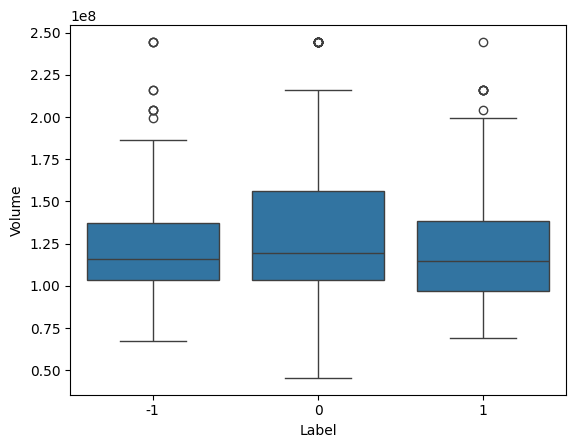

In [23]:
sns.boxplot(
    data=stock, x="Label", y="Volume"  # plot a boxplot of Label vs Volume
);

#### Date vs Price (Open, High, Low, Close)

In [24]:
stock_daily = stock.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


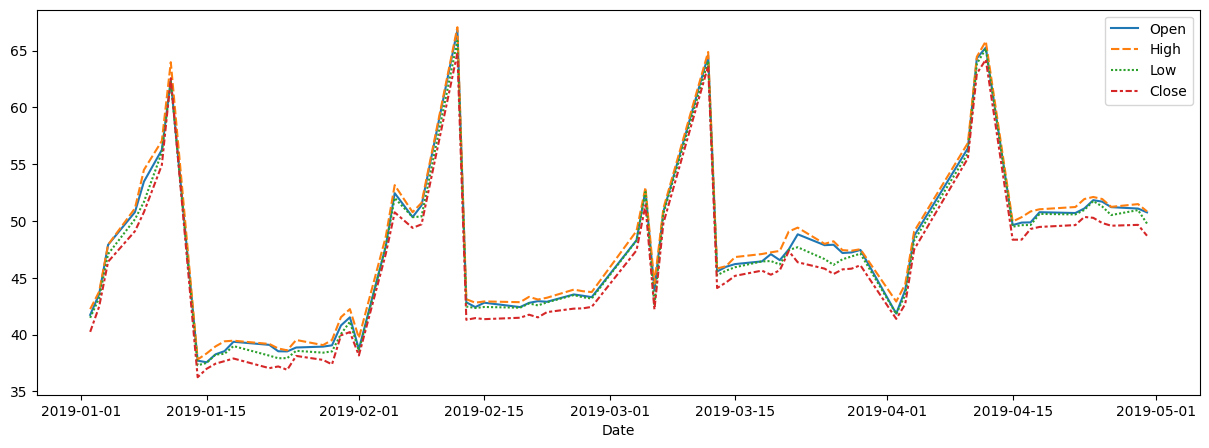

In [25]:
plt.figure(figsize=(15, 5))


sns.lineplot(stock_daily.drop("Volume", axis=1)); # plot a lineplot of all the variables except Volume

#### Volume vs Close Price

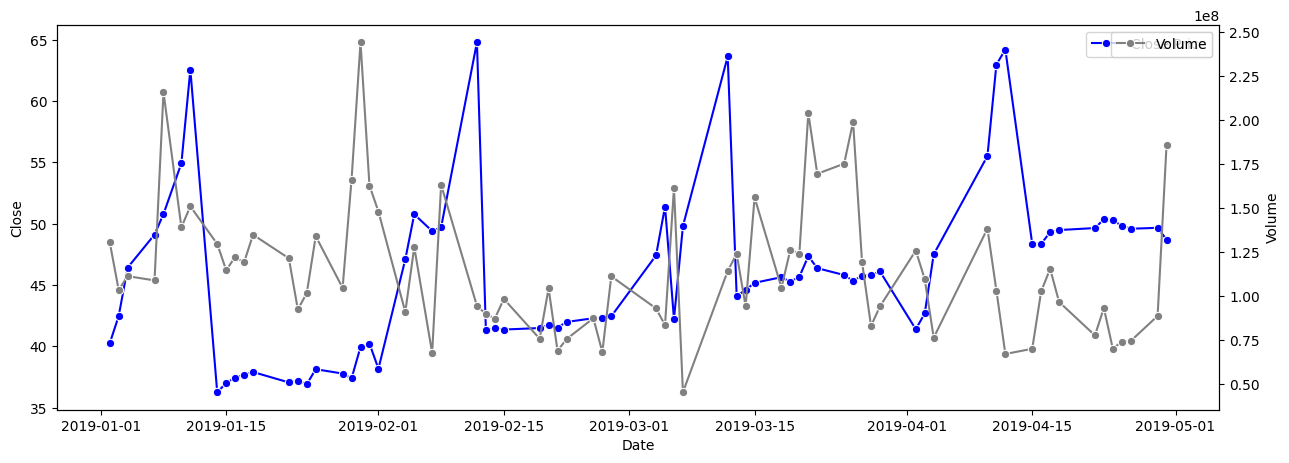

In [26]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

## **Data Preprocessing**

In [27]:
stock["Date"].T

,Date
0,2019-01-02
1,2019-01-02
2,2019-01-02
3,2019-01-02
4,2019-01-02
...,...
344,2019-04-30
345,2019-04-30
346,2019-04-30
347,2019-04-30


### Train-test-validation Split

In [28]:
X_train = stock[(stock['Date'] < '2019-04-01')].reset_index()    #select all rows where the 'Date' is before '2019-04-01'
X_val = stock[(stock['Date'] >= '2019-04-01') & (stock['Date'] < '2019-04-16')].reset_index()    #select all rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded)
X_test = stock[stock['Date'] >= '2019-04-16'].reset_index()    #select all rows where the 'Date' is from '2019-04-16' till the end.

In [29]:
y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()

In [30]:
# Print the shape of X_train,X_val,X_test,y_train,y_val and y_test
print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 10)
Validation data shape (21, 10)
Test data shape  (42, 10)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


## **Word Embeddings**

In [31]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stock['News'].values]

In [32]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [33]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


Let's check out a few word embeddings obtained using the model.


In [34]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([ 3.80943110e-03,  4.34087999e-02,  5.71310706e-03,  2.40936745e-02,
       -3.82764894e-03, -5.02618738e-02,  3.54611836e-02,  8.40092972e-02,
        9.98440478e-03, -1.51219638e-02,  1.17555344e-02, -2.25186720e-02,
        1.24008127e-03,  1.19033810e-02, -2.91088913e-02, -2.51745097e-02,
        2.13982146e-02, -1.22337397e-02, -1.98488147e-03, -1.37469200e-02,
       -2.72227507e-02,  2.86850729e-03,  3.72824967e-02,  7.15060858e-03,
        1.48285804e-02,  6.19999506e-03, -4.45299335e-02,  6.43149624e-03,
       -1.84769984e-02, -3.57402526e-02,  1.41944094e-02, -2.14447491e-02,
        3.05473432e-03, -2.95612798e-03, -5.09254122e-03,  1.66635029e-02,
        1.67979803e-02, -3.79191414e-02,  2.24837172e-03, -1.06391339e-02,
       -1.61985364e-02, -1.81044510e-03, -2.06857920e-03, -2.61509083e-02,
        1.58617403e-02,  3.95524614e-02, -9.93066496e-05,  9.69038438e-03,
       -1.98977627e-03,  2.70023402e-02,  2.00405959e-02,  5.17581124e-03,
       -1.66385341e-02,  

In [35]:
# Checking the word embedding of a random word
word = "economy"
model_W2V.wv[word]

array([ 2.52412749e-03,  6.33442495e-03,  4.99765483e-05,  3.59334005e-03,
       -2.56990874e-03, -8.56135134e-03,  8.61086976e-03,  1.56220766e-02,
        4.76709130e-04, -1.36184820e-03,  2.47656996e-03, -4.59636841e-03,
        7.51127023e-04,  2.00237660e-03, -4.82743839e-03, -3.30431410e-03,
        2.34106975e-03, -3.29827867e-03, -5.72915014e-04, -3.92195163e-03,
       -1.28196797e-03,  1.68422086e-03,  5.23746340e-03,  2.26552808e-03,
        4.59872046e-03,  1.62239082e-03, -4.62215720e-03, -1.32713490e-03,
       -2.50552176e-03, -5.77818835e-03,  3.01179057e-03, -2.05479143e-03,
        3.10042058e-03, -1.72360789e-03,  1.24489816e-04,  3.52652557e-03,
        1.43109530e-03, -2.91825505e-03,  6.21766958e-04, -1.81248272e-03,
       -4.73307632e-03,  4.81617200e-04,  1.29782245e-03, -5.15923137e-03,
       -1.05989899e-03,  6.74045319e-03, -1.71500572e-03,  4.88642091e-03,
       -2.86033354e-03,  5.85892284e-03,  6.70531299e-04, -1.22164580e-04,
       -2.33266130e-03,  

In [36]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [37]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [38]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.5407235622406006


In [39]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


### GloVe Analysis

In [40]:
!wget -c http://nlp.stanford.edu/data/glove.6B.zip # -c flag ensures that download is resumed
!unzip -o glove.6B.zip # -o flag overwrites existing files if any

from gensim.models import KeyedVectors
import time

# Wait for download to complete
time.sleep(10)

from gensim.scripts.glove2word2vec import glove2word2vec

# Input and output file paths
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'

# Convert GloVe format to Word2Vec format
glove2word2vec(glove_input_file, word2vec_output_file)

# load the Stanford GloVe model
# Path to the converted file
filename = 'glove.6B.100d.word2vec.txt'

# Load the Word2Vec format file
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

--2024-11-20 17:07:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-20 17:07:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-20 17:07:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [41]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [42]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [43]:
# Checking the word embedding of a random word
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [44]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [45]:
vec_size=100

In [46]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [47]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) # apply GloVe on 'News' column
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) # apply GloVe on 'News' column
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) # apply GloVe on 'News' column

end = time.time()
print('Time taken ', (end-start))

Time taken  26.066519498825073


In [48]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape) # Print the shapes of the final dataframes


(286, 100) (21, 100) (42, 100)


### Sentence Transformer

#### Defining the model

In [49]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Encoding the dataset

In [50]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device) # apply Sentence Transformer on 'News' column
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device) # apply Sentence Transformer on 'News' column
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device) # apply Sentence Transformer on 'News' column

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  1.5431571006774902


In [52]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape) # print the shapes of the final dataframes

(286, 384) (21, 384) (42, 384)


## **Sentiment Analysis**

### Utility Functions

In [53]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [54]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

In [55]:
# Building the model


#base_wv = GradientBoostingClassifier(random_state = 42)
#base_wv = RandomForestClassifier(random_state=42)
base_wv = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

DecisionTreeClassifier(random_state=42)

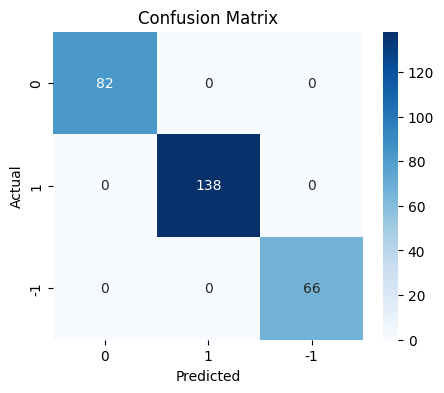

In [56]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

In [57]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [58]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.342857  0.380952


### Base Model - GloVe

In [59]:
#Building the model

base_gl = RandomForestClassifier(random_state=42)

# Fitting on train data
base_gl.fit(X_train_gl, y_train) #Complete the code to fit the chosen model on the train data

RandomForestClassifier(random_state=42)

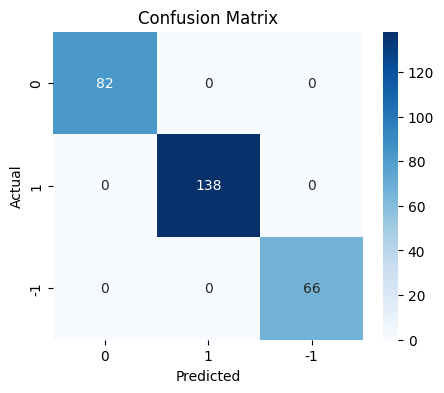

In [60]:
plot_confusion_matrix(base_gl,X_train_gl,y_train)

In [61]:
#Calculating different metrics on training data
base_train_gl = model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [62]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.342857  0.380952


### Base Model - Sentence Transformer


In [63]:
# Building the model

base_st = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_st.fit(X_train_st, y_train) #fit the chosen model on the train data

GradientBoostingClassifier(random_state=42)

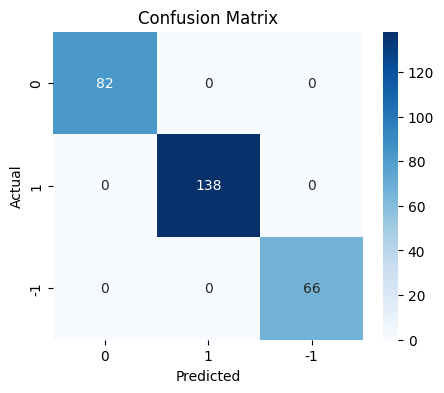

In [64]:
plot_confusion_matrix(base_st,X_train_st,y_train)

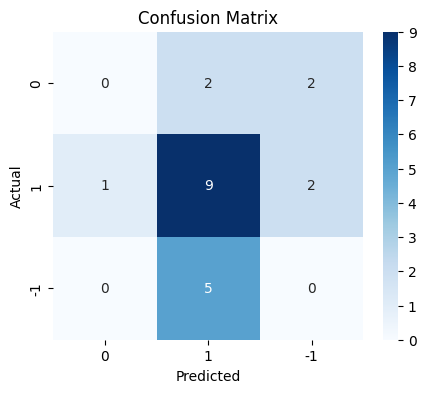

In [65]:
plot_confusion_matrix(base_st,X_val_st,y_val)


In [66]:
#Calculating different metrics on training data
base_train_st=model_performance_classification_sklearn(base_st,X_train_st,y_train) # compute the model performance for the training data
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [67]:
#Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_st,X_val_st,y_val) # compute the model performance for the validation data
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.321429  0.367347


### Tuned Model - Word2Vec

In [68]:
import time
start = time.time()

# Choose the type of classifier.

tuned_wv = DecisionTreeClassifier(random_state=42)


parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  2.5674777030944824


In [69]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

DecisionTreeClassifier(max_depth=3, max_features=0.4, min_samples_split=5,
                       random_state=42)

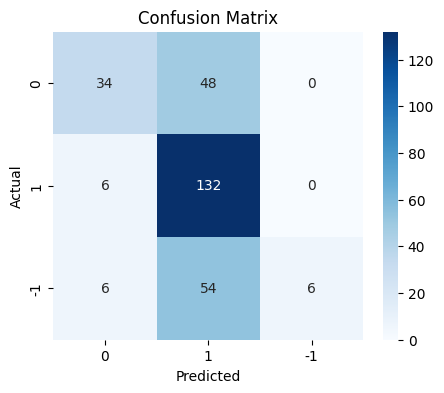

In [70]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

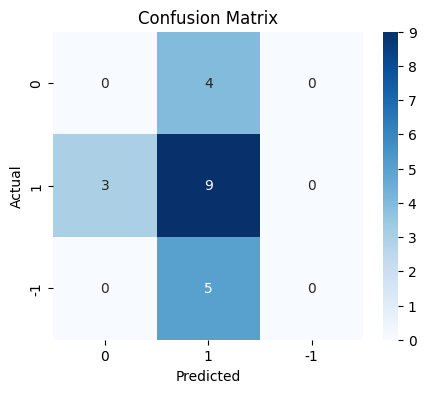

In [71]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [72]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision       F1
0  0.601399  0.601399   0.714877  0.53321


In [73]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.285714  0.342857


#### Tuned the GloVe model

In [74]:
start = time.time()

tuned_gl = RandomForestClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  18.183690309524536


In [75]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=7,
                       random_state=42)

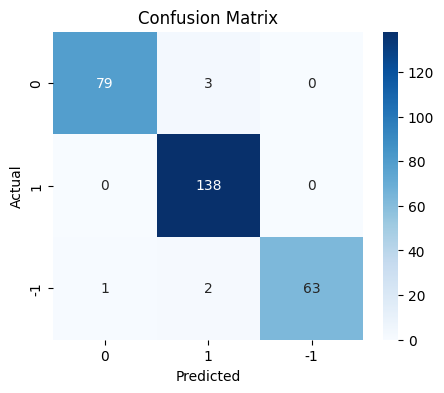

In [76]:
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

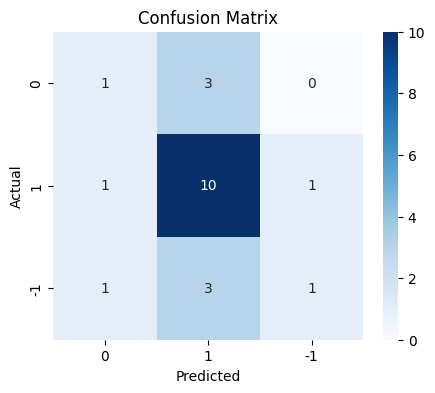

In [77]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

In [78]:
#Calculating different metrics on training data
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train) #compute the model performance for the training data
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.979021  0.979021   0.979545  0.978968


In [79]:
#Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val) #compute the model performance for the validation data
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.539683  0.530612


### Tuned Model - Sentence Transformer

In [80]:
import time
start = time.time()


tuned_wv = GradientBoostingClassifier(random_state = 42)


parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  144.12768363952637


In [81]:
#Calculating different metrics on training data
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st,y_train) #compute the model performance for the training data
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [82]:
#Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val) #compute the model performance for the validation data
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381   0.314286  0.392857


### Model Performance Summary and Final Model Selection

In [83]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,0.601399,0.979021,1.0
Recall,1.0,1.0,1.0,0.601399,0.979021,1.0
Precision,1.0,1.0,1.0,0.714877,0.979545,1.0
F1,1.0,1.0,1.0,0.533210,0.978968,1.0


In [84]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.428571,0.476190,0.428571,0.428571,0.571429,0.523810
Recall,0.428571,0.476190,0.428571,0.428571,0.571429,0.523810
Precision,0.342857,0.400794,0.321429,0.285714,0.539683,0.314286
F1,0.380952,0.426871,0.367347,0.342857,0.530612,0.392857


### Model Performance Check on Test Data

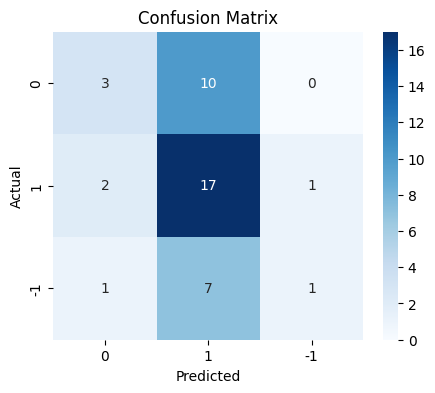

In [85]:
plot_confusion_matrix(tuned_gl,X_test_gl,y_test)

In [86]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(tuned_gl,X_test_gl,y_test) # compute the final model's performance for the test data
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy  Recall  Precision        F1
0       0.5     0.5        0.5  0.436529


## **Weekly News Summarization**

It is recommended to run this section of the project independently from the revious sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries


In [87]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 141.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 258.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 216.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 347.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
langchain 0.3.7 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>=1.21, but you have numpy 2.1.3 whic

In [88]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

In [89]:
# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

In [90]:
# Importing the library for data manipulation
import pandas as pd


In [91]:
from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

# To manipulate and analyze data
import pandas as pd
import numpy as np



#### Loading the data

In [92]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path="drive/MyDrive/AIML/StockMarket"


Mounted at /content/drive


In [93]:
import pandas as pd
stock_news = pd.read_csv(path+'/stock_news.csv')
data = stock_news.copy()

#### Loading the model

In [94]:
from huggingface_hub import hf_hub_download

# Specify the model repo id and the filename of the model file to download
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"

# This might be the filename of the model in the repo, but confirm the exact name.
model_basename = "llama-2-13b-chat.Q2_K.gguf"  # Change this filename based on the actual file in the repo

# Download the model file
model_path = hf_hub_download(
    repo_id=model_name_or_path,  # The model's repo ID on Hugging Face
    filename=model_basename      # The specific model file to download
)

print(f"Model downloaded to: {model_path}")



llama-2-13b-chat.Q2_K.gguf:   0%|          | 0.00/5.43G [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q2_K.gguf


In [95]:
llm = Llama(
    model_path=model_path,
    n_ctx=4500, # Context window
    n_threads=-2 # Number of CPU cores to use
 )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


#### Aggregating the data weekly

In [96]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [97]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [98]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [99]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [100]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [101]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [102]:

# Updated Implementation of generate_llama_response
def generate_llama_response(instruction, review, temperature):
    # Seed is set during Llama object initialization
    lcpp_llm = llama_cpp.Llama(model_path=model_path, n_ctx=4500, seed=1234)
    prompt = f"""
    {instruction}
    ###
    {review}
    ###
    Response:
    """

    # Removed seed from here as it's already set during initialization
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=4500,
        temperature=temperature,
        top_p=0.95,
        top_k=40,
        repeat_penalty=1.1,
        stop=["###"],
    )
    return response['choices'][0]['text']




##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [103]:
news = data_1.loc[0, 'News']

In [104]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [105]:

# defining the instructions for the model
instruction_1 = """
You are a helpful assistant.

    Task: Analyze the following news to identify positive and negative events within the text.

    Instructions:
    1. Read the news carefully.
    2. Extract positive events (if any) and negative events (if any).
    3. Return the results in JSON format.

    Example input:
    "Stock prices surge as tech companies report record profits despite market volatility."

    Example output:
    {{
      "positive_events": ["Stock prices surge", "Record profits for tech companies"],
      "negative_events": ["Market volatility"]
    }}

    Input: "{news_text}"

    Output:

"""








##### Checking the model output on the weekly data

In [106]:
import llama_cpp
weekly_grouped_forAnalysis_1 = weekly_grouped.copy()
weekly_grouped_forAnalysis_1['Key Events'] = weekly_grouped_forAnalysis_1['News'].apply(lambda x: generate_llama_response(instruction_1, x,0))




AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI

##### Formatting the model output

In [107]:
weekly_grouped_forAnalysis_1['model_response_parsed'] = weekly_grouped_forAnalysis_1['Key Events'].apply(extract_json_data)
weekly_grouped_forAnalysis_1.head()


    Positive events:
        - Stock prices surge
        - Record profits for tech companies
        - AMS provides optical sensors for 3D facial recognition features on Apple's iPhones
        - Former Goldman Sachs China economist expects U.S.-China trade talks to progress
        - The Chinese authorities are expected to release a statement following the conclusion of U.S. trade talks in Beijing
        - Xiaomi Co-founder remains optimistic about the future of his smartphone company
        - Taiwan's Foxconn reported an 8.3% decline in December revenue
        - Starting tomorrow, JD.com will offer reduced prices on some Apple iPhone 8 and 8 Plus models
        - Cummins, Inc. announced that Pat Ward, its long-term Chief Financial Officer, will retire after 31 years of service
        - The Federal Reserve Chairman maintained his patient stance on monetary policy but raised concerns about the balance sheet reduction
        - Green Dot is a bank holding company with a wide distri

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"\n {\n ""positive_events"": [\n ...","{'positive_events': ['US-China trade talks', '..."
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,\n Positive events:\n - Stock prices...,{}
2,2019-01-20,The U.S. stock market declined on Monday as c...,"\n {\n ""positive_events"": [],\n ""...","{'positive_events': [], 'negative_events': ['M..."
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",\n Positive events:\n * Stock prices...,{}
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,\n Positive events:\n * Apple report...,{}


In [108]:

model_response_parsed = pd.json_normalize(weekly_grouped_forAnalysis_1['model_response_parsed'])

model_response_parsed.head()

,positive_events,negative_events
0,"[US-China trade talks, better-than-expected jo...","[Apple's revenue forecast cut, weak demand for..."
1,NaN,NaN
2,[],"[Market volatility, Record profits for tech co..."
3,NaN,NaN
4,NaN,NaN


In [109]:
final_output = pd.concat([weekly_grouped_forAnalysis_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,"[US-China trade talks, better-than-expected jo...","[Apple's revenue forecast cut, weak demand for..."
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,NaN,NaN
2,2019-01-20,The U.S. stock market declined on Monday as c...,[],"[Market volatility, Record profits for tech co..."
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",NaN,NaN
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,NaN,NaN


## **Conclusions and Recommendations**

Model Used - GloVe, Sentence transformer and Word2Vec; Tuned GloVe is the best amonth them as preision,recall and accuarcy is almost same and high 0.5.

Weekly summarization used model TheBloke/Llama-2-13B-chat-GGUF and summarized them based on sentiments (positive,negative).

Following are the findings and conclusion   -

#### Key Findings
#### Sentiment Distribution:

Neutral Sentiment (0): Dominates with 170 articles (48.7%).
Negative Sentiment (-1): Comprises 99 articles (28.4%).
Positive Sentiment (1): Comprises 80 articles (22.9%).

#### Correlation Analysis:

Sentiment (Label) shows weak positive correlations with stock prices (Open, High, Low, Close), suggesting that sentiment has some influence but is not the sole driver of price movements.
Volume shows a very weak negative correlation with sentiment, indicating trading activity might not directly correlate with the tone of the news.

#### Sentiment Trends:

Average weekly sentiment values show a mix of negative and positive sentiment weeks, with fluctuations across the observed time period.

#### Correlation Insights:

#### Positive but weak correlation:

Weekly sentiment shows a slight positive correlation with stock prices (Avg Open, Avg High, Avg Low, Avg Close), suggesting that higher sentiment (positive news) aligns with modest increases in stock performance.

#### Negative correlation with trading volume:

Sentiment has a moderate negative correlation with weekly total trading volume, indicating that heightened trading activity might not always reflect positive market sentiment.

#### Stock Performance Trends:

Weeks with stronger positive sentiment tend to have slightly higher average stock prices. Neutral or negative sentiment weeks generally coincide with reduced stock performance metrics.

#### Conclusion

The analysis confirms that news sentiment is an important but not sole driver of stock prices. While positive sentiment tends to align with better stock performance, other factors like market conditions and trading volumes also play significant roles. Aggregating data weekly reveals broader trends, reducing the noise inherent in daily fluctuations.


#### Recommendations

#### Sentiment Analysis for Forecasting:

Incorporate external features like sector-wide performance or economic indicators to improve prediction accuracy.

#### Dashboard for Financial Analysts:

Create a visualization tool that highlights weekly sentiment trends, stock performance, and trading volumes. This will enable analysts to identify opportunities and risks.

#### Real-Time Sentiment Updates:

Implement a real-time system to score sentiment on incoming news articles. Use the weekly trends from historical data as benchmarks for real-time decision-making.

#### Sentiment-Driven Investment Strategies:

Explore strategies such as increasing exposure to stocks during highly positive sentiment weeks while exercising caution in neutral or negative sentiment weeks.

#### Retrain Models Regularly:

Update the sentiment model with new data to adapt to changing market dynamics and news content styles, ensuring relevance over time.






-




<font size=6 color='blue'>Power Ahead</font>
___